In [355]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from IPython.display import Image
import copy

pal = sns.color_palette()
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'



In [386]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


### Feature Engineering

We will work on the logarithmic of migration data. As regards inputs, we consider their log-transforms for inputs that have positive values only. We  keep the intercept, to consider the "independent" flow of migration, i.e. not related to other variables.

We transform both input and output as below:
* Output $y = log_{10} (E)$
* Input with values in $R^+$: $x_i = log_{10} (I_i)$ (multiplicative factors)
* Input with values in $R$ : $x_i = I_i$ (additive factors)


so that the model that we identify, here below: 

---
$y = \alpha_0 + \alpha_1 \cdot x_1 + \alpha_2 \cdot x_2 + \alpha_3 \cdot x_3  \ldots$   (multiplicative factors)



$\ldots \alpha_4 x_4 + \alpha_5 x_5$ (additive factors)


is equivalent to

---
$exp (E) = exp( \alpha_0  + \alpha_1 \log {I_1} + \alpha_2 \log {I_2} + \alpha_3 \log {I_3} + \ldots$ 

$\ldots + \alpha_4 I_4 + \alpha_5 I_5)$



hence to a multiplicative model, as below

___
$E = e ^{\alpha_0} \cdot {I_1}^{\alpha_1}\cdot {I_2}^{\alpha_2}\cdot {I_3}^{\alpha_3} \cdot \ldots$

$\ldots \cdot \exp (I_4)^{\alpha_4} \cdot  \exp(I_5)^{\alpha_5} $



#### Metric
___
We will use the mean absolute error, or other... TODO 

In [141]:
from sklearn.linear_model import LassoCV, Lasso, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler,robust_scale
from migration import sel_regressor

#### Data loading

In [445]:
data_tot = pd.read_csv('data/emigration_indicators_data.csv')

### Target selection

One can select here if model on relative emigration (i.e., % of country population) or absolute. This can be done setting variable * absolute * to ``True`` or to ``False``. 

In [446]:
absolute = True

In [447]:
target = 'Log of Emigration, total'
to_drop = 'Log of Emigration, % pop'

if absolute==False:
    target, to_drop = to_drop, target

data_tot = data_tot.drop(['CountryCode','Emigration, % pop','Emigration, total',to_drop],axis=1)
data_tot_ = pd.get_dummies(data_tot)
X,y,input_name = sel_regressor(data_tot_,target)

### Preprocessing

Split the dataset in training and testing

In [338]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

Standardize the dataset 

In [364]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.fit_transform(X)

## Model

### Model Identification

In [316]:
par_range = {'alpha':np.logspace(np.log10(0.9), np.log10(0.0001), num=10)}

lasso_search = GridSearchCV(Lasso(max_iter=10000000), par_range, verbose=1)
lasso_search.fit(X_train_scaled,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([9.00000e-01, 3.27252e-01, 1.18993e-01, 4.32675e-02, 1.57326e-02,
       5.72059e-03, 2.08008e-03, 7.56346e-04, 2.75017e-04, 1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [317]:
cv_results_df = pd.DataFrame(lasso_search.cv_results_)
cv_results_df = cv_results_df.set_index(cv_results_df['param_alpha'])
cv_results_df.head(20)

/Users/lraso/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/lraso/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/lraso/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/lraso/anaconda/lib/python3.5/

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
param_alpha,,,,,,,,,,,,,,,,,
0.900000,0.003704,0.000732,-0.000819,0.000000,0.9,{'alpha': 0.9},9,-0.000186,0.000000,-0.000727,0.000000,-0.001547,0.000000,0.000605,0.000052,0.000560,0.000000
0.327252,0.003128,0.000549,-0.000819,0.000000,0.327252,{'alpha': 0.3272519406160839},9,-0.000186,0.000000,-0.000727,0.000000,-0.001547,0.000000,0.000617,0.000041,0.000560,0.000000
0.118993,0.002723,0.000734,0.103543,0.108056,0.118993,{'alpha': 0.11899314737443656},8,0.085283,0.089264,0.169943,0.183851,0.055495,0.051053,0.000343,0.000179,0.048445,0.055820
0.043267,0.019213,0.000540,0.589001,0.594365,0.0432675,{'alpha': 0.043267487109222263},7,0.580469,0.576622,0.561842,0.630849,0.624735,0.575624,0.002250,0.000141,0.026358,0.025801
0.015733,0.133674,0.000592,0.696885,0.713352,0.0157326,{'alpha': 0.015732632357860425},6,0.712707,0.690894,0.646716,0.743549,0.731153,0.705613,0.058988,0.000259,0.036223,0.022182
0.005721,0.178237,0.000412,0.739655,0.764776,0.00572059,{'alpha': 0.005720593855676909},4,0.771899,0.745696,0.682744,0.788519,0.764157,0.760111,0.168889,0.000018,0.040315,0.017791
0.002080,0.121649,0.000710,0.756842,0.806661,0.00208008,{'alpha': 0.002080083823051904},2,0.794799,0.787225,0.707041,0.819472,0.768494,0.813285,0.043417,0.000436,0.036775,0.013973
0.000756,0.749888,0.000525,0.759410,0.849085,0.000756346,{'alpha': 0.0007563460752642876},1,0.807059,0.832082,0.715030,0.855464,0.755901,0.859708,0.271498,0.000153,0.037668,0.012147
0.000275,3.581578,0.000498,0.753917,0.875309,0.000275017,{'alpha': 0.0002750174676751074},3,0.808855,0.859221,0.718826,0.879160,0.733793,0.887545,1.419103,0.000062,0.039420,0.011880


[]

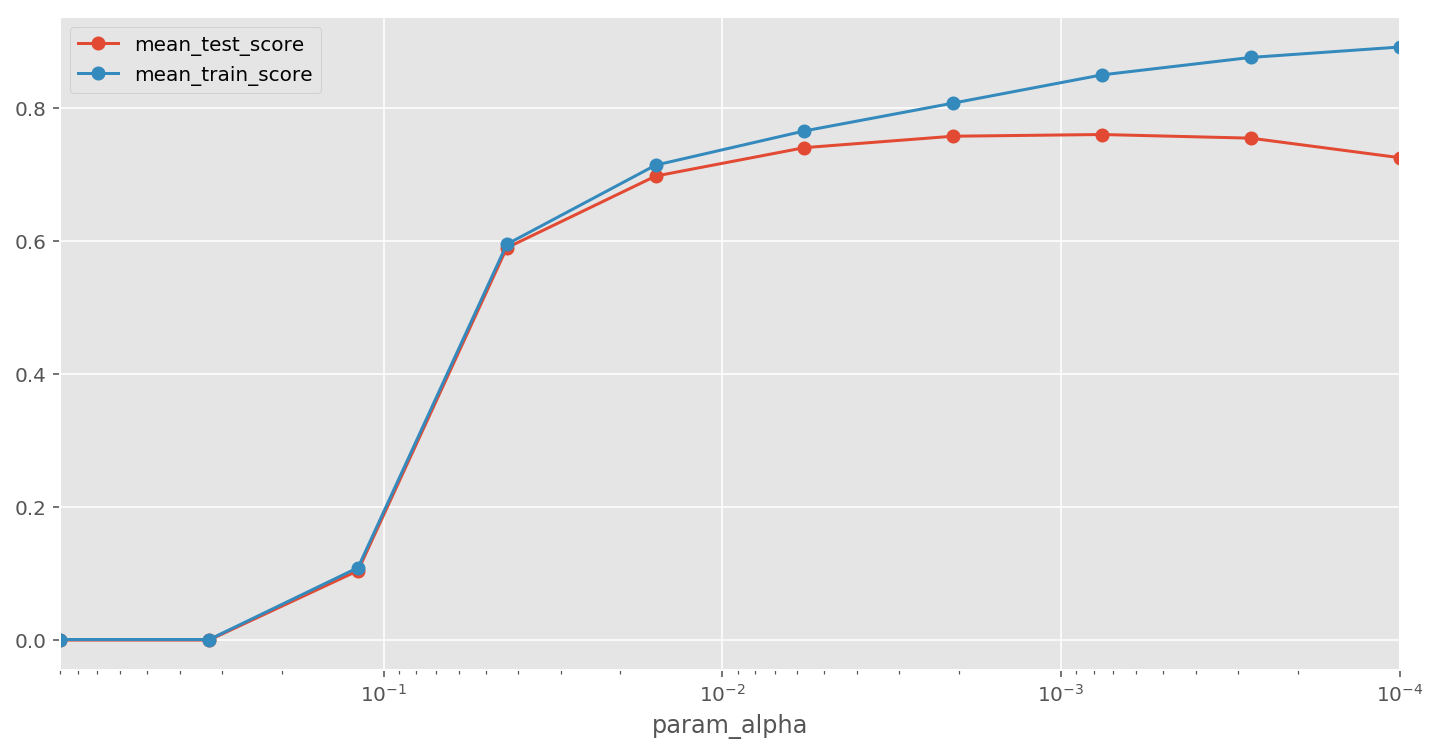

In [318]:
cv_results_df[['mean_test_score','mean_train_score']].plot(marker='o').semilogx()

In [340]:
best_lasso = lasso_search.best_estimator_
best_lasso_coeff_df = pd.Series(best_lasso.coef_,index = input_name).copy()
best_lasso_coeff_df[best_lasso_coeff_df==0] = np.nan
best_lasso_coeff_df = best_lasso_coeff_df.dropna(axis='index')

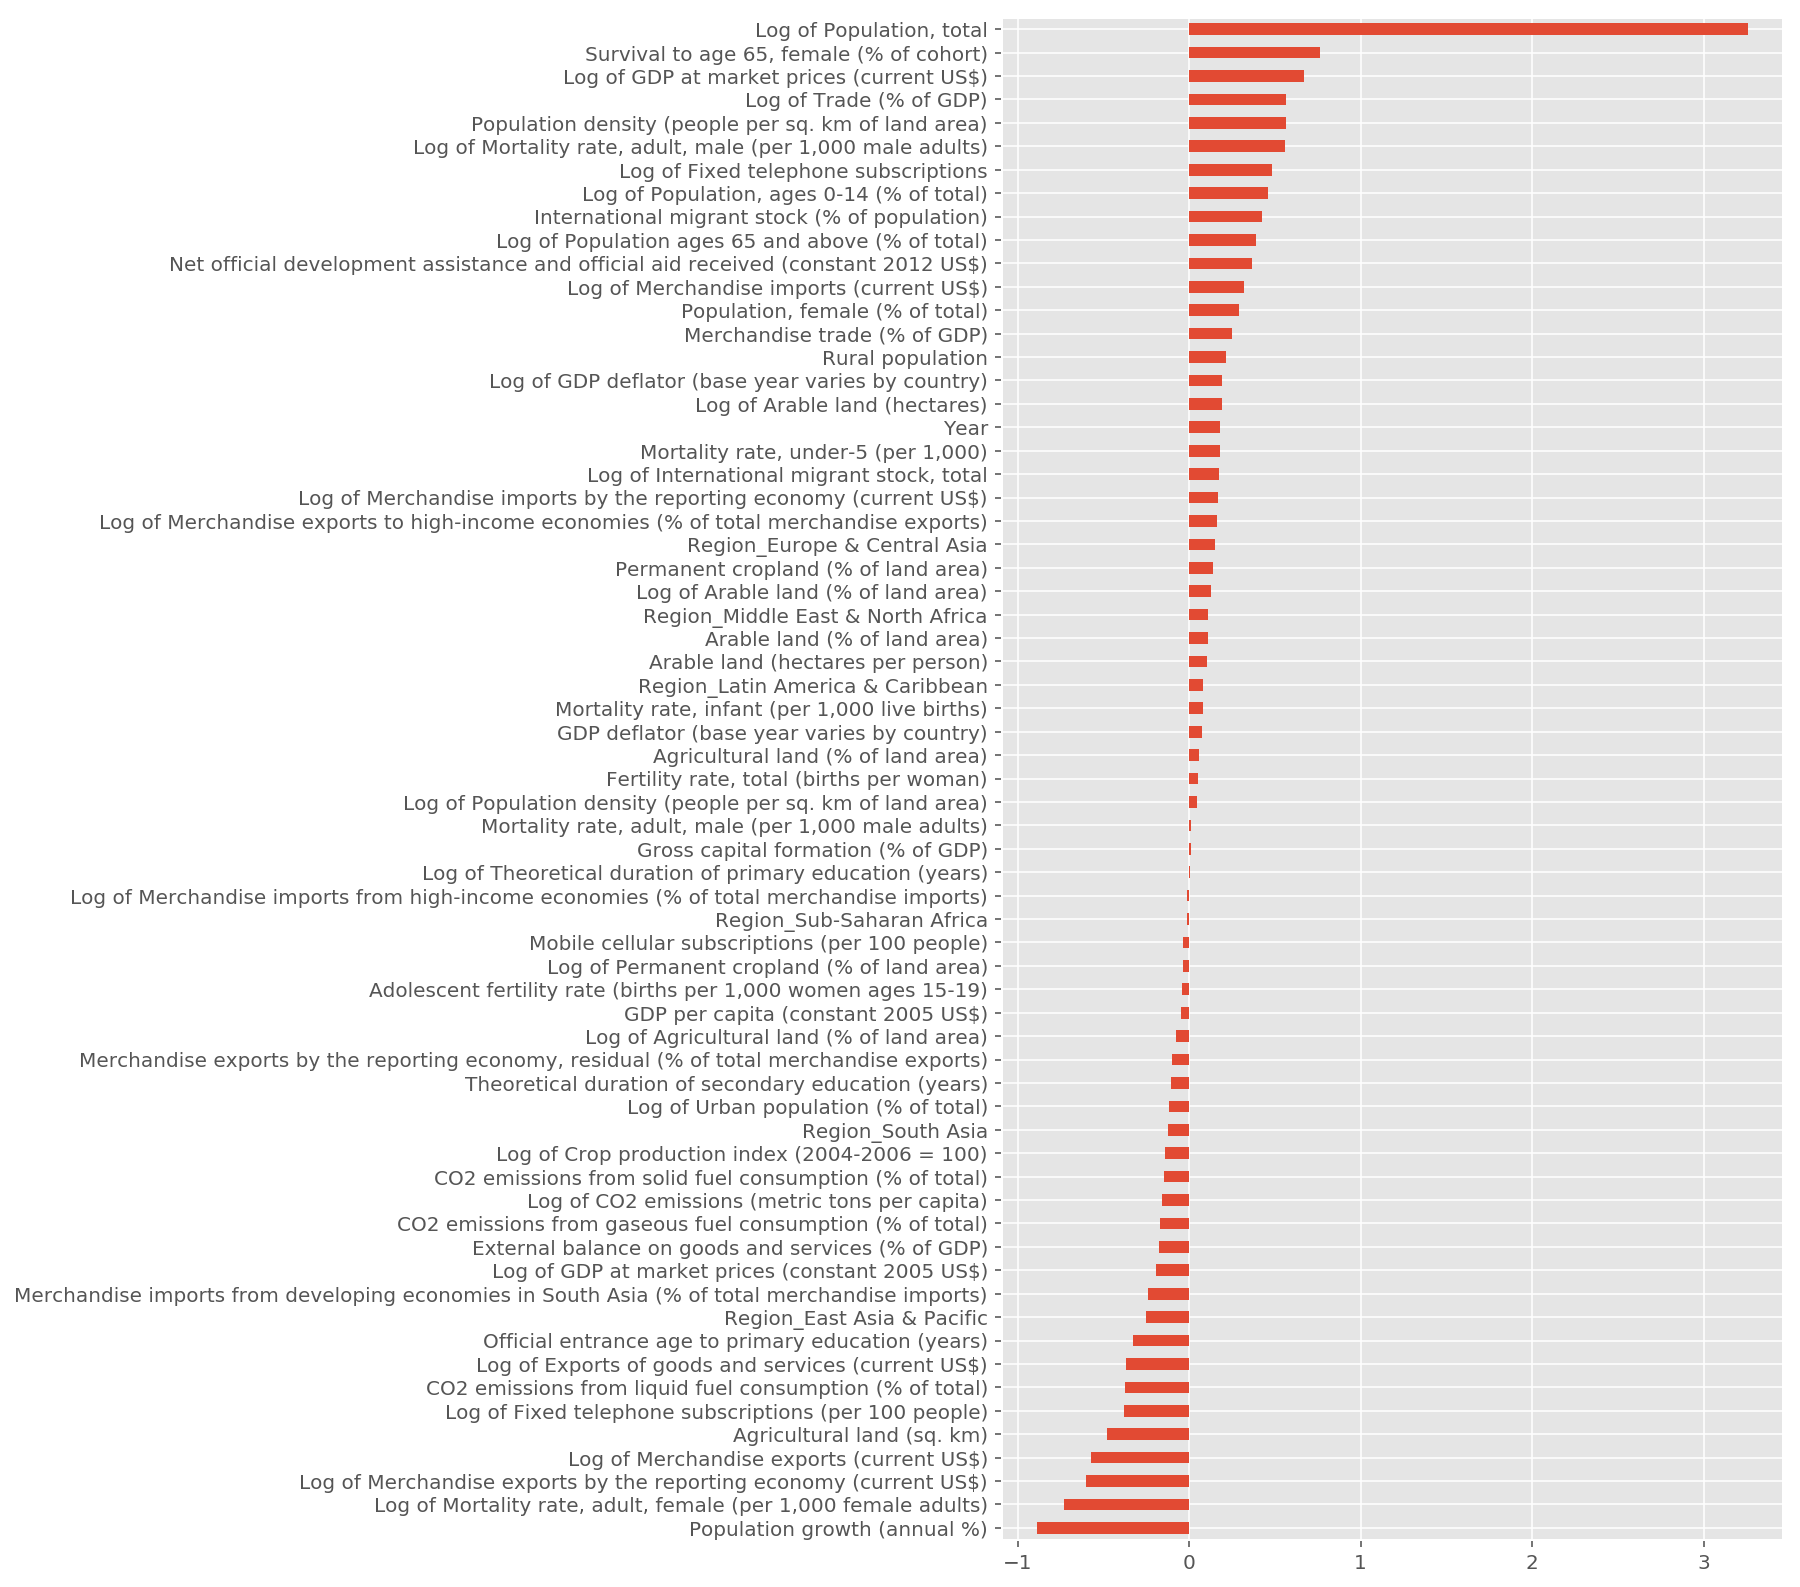

In [341]:
best_lasso_coeff_df.sort_values().plot(kind='barh',figsize=(7,14))

### Parsimonious model

In [342]:
small_lasso = Lasso(alpha=5*10**(-3)).fit(X_train_scaled,y_train)
small_lasso.score(X_train_scaled,y_train)

0.7585590987554265

In [343]:
small_lasso_coeff_df = pd.Series(small_lasso.coef_,index = input_name).copy()
small_lasso_coeff_df[small_lasso_coeff_df==0] = np.nan
small_lasso_coeff_df = small_lasso_coeff_df.dropna(axis='index')

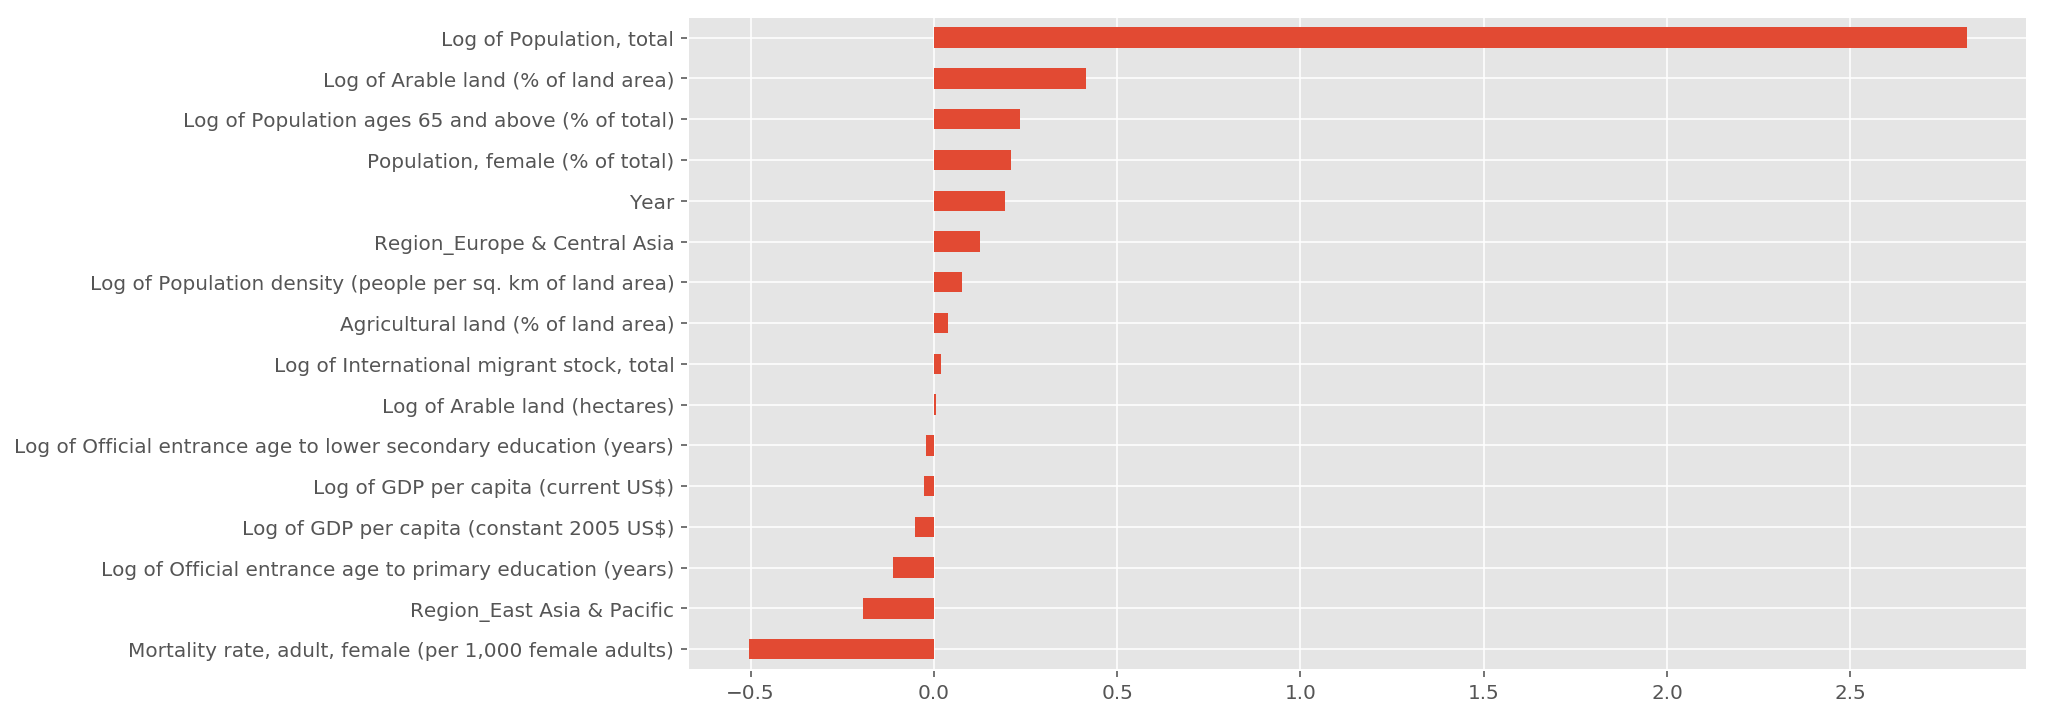

In [448]:
small_lasso_coeff_df.sort_values().plot(kind='barh')

____
TO DO: Comment this

### Single factor effect

Analyse the effect of each indicator. By plotting. 

In [453]:
def single_factor_plot (name_factor):
    """ Plot effect of single factor on model output"""

    pos_factor = np.where(input_name==name_factor)[0][0]
    X_factor = X_scaled[:,pos_factor]

    X_partial_scaled = copy.deepcopy(X_scaled)
    X_partial_scaled[:,pos_factor] = np.mean(X_factor)

    y_partial = best_lasso.predict(X_partial_scaled)
    best_score = best_lasso.score(X_scaled, y)
    loss_score = best_score - best_lasso.score(X_partial_scaled, y)
    err = y - y_partial
    plt.scatter(X_factor,err,marker='.')
    plt.title('Influence of single factor, $R^2$: ' + str(loss_score)[0:6])
    plt.xlabel(name_factor)
    plt.ylabel('Model output')

We selected two factor particularly interesting for the ``best`` model: 
* (Annual) Population growth
* (Log of) Trade in & of GDP

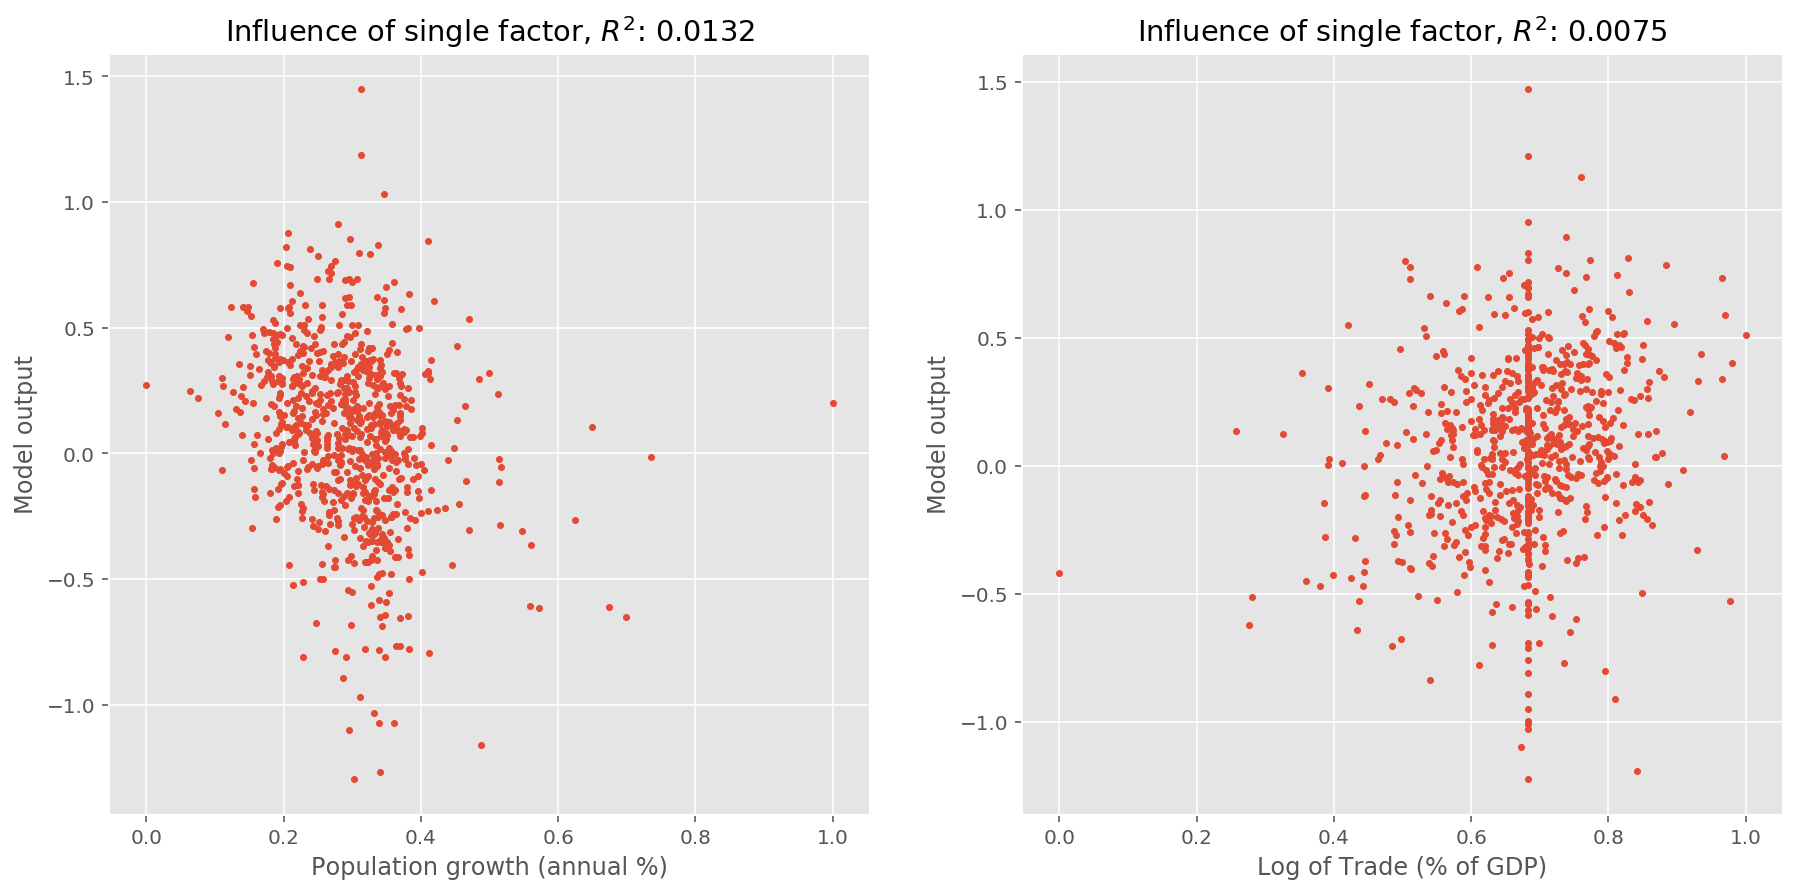

In [454]:
plt.figure(figsize=(15,7))
plt.subplot(121)
single_factor_plot('Population growth (annual %)')
plt.subplot(122)
single_factor_plot('Log of Trade (% of GDP)')

___
Comments to this figure. 


In [412]:
small_lasso.score(X_test_scaled, y_test)

-0.6392570371166337

### Model evaluation

In [413]:
X_test_scaled = scaler.transform(X_test)

In [417]:
best_lasso.score(X_test_scaled, y_test)

0.822249460798544

In [418]:
y_test_predict = best_lasso.predict(X_test_scaled)

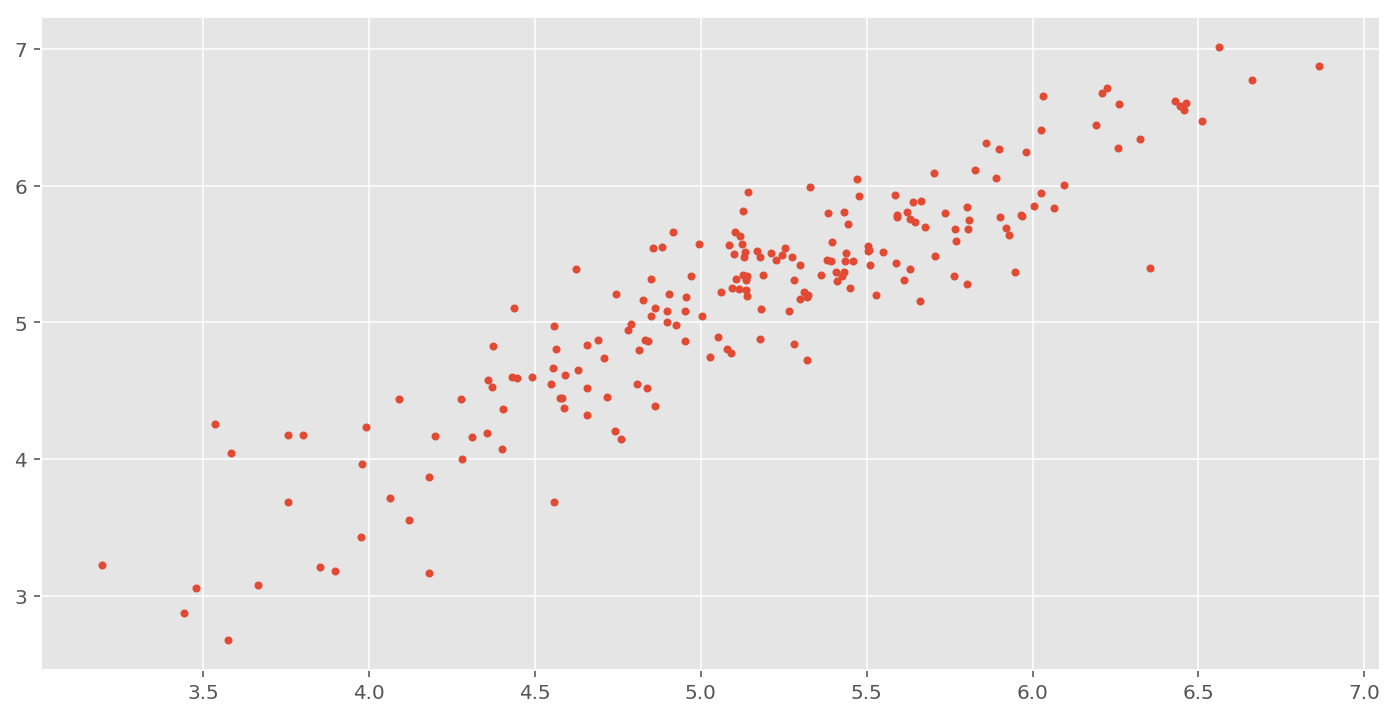

In [420]:
plt.plot(y_test_predict,y_test,'.')

In [8]:
df_lasso_coeff = pd.DataFrame(index=[*input_name,'N param','Score test', 'Score train','Score cv'])
range_alpha = np.logspace(np.log10(0.9), np.log10(0.00005), num=15)


for alpha in par_range['alpha']:
    
    #cv_outer = KFold(len(X), n_folds=5)
    model_lasso = Lasso(alpha=alpha,max_iter=10000000).fit(X_train_scaled,y_train)
    
    score_train = model_lasso.score(X_train_scaled,y_train)
    score_test = model_lasso.score(X_scaled,y)
    
    #lasso = LassoCV(cv=3)  # cv=3 makes a KFold inner splitting with 3 folds
    cv_score = cross_val_score(model_lasso, X_train_scaled, y_train, cv=3)
    
    y_model = model_lasso.predict(X_test_scaled)
    #score_test_acc = accuracy_score(y_test,y_model)
    
    alpha_lasso_coeff = pd.Series(model_lasso.coef_,index =input_name)
    alpha_lasso_coeff[alpha_lasso_coeff==0] = np.nan
    df_lasso_coeff[alpha]=alpha_lasso_coeff
    df_lasso_coeff[alpha]['Score train']= score_train
    df_lasso_coeff[alpha]['Score test']= score_test
    df_lasso_coeff[alpha]['Score cv'] = cv_score.mean()
    #df_lasso_coeff[alpha]['Score test accur']= score_test_acc
    df_lasso_coeff[alpha]['N param'] = sum(~np.isnan(model_lasso.coef_))
    
    #print('alphas : '+ str(model_lasso.alphas_))
    #print('alpha: '+str(model_lasso.alpha_))
    print(alpha)
    print(cv_score)
    print ('\n\n')

0.9
[-2.66876619e-03 -3.08585019e-07 -2.31431969e-03]



0.6526100518878702
[-2.66876619e-03 -3.08585019e-07 -2.31431969e-03]



0.47322208869454296
[-2.66876619e-03 -3.08585019e-07 -2.31431969e-03]



0.3431438798415911
[-2.66876619e-03 -3.08585019e-07 -2.31431969e-03]



0.24882127247602875
[-2.66876619e-03 -3.08585019e-07 -2.31431969e-03]



0.18042584837931894
[-2.66876619e-03 -3.08585019e-07 -2.31431969e-03]



0.130830802525267
[-0.00266877  0.07607363 -0.00231432]



0.09486832980505137
[0.32267798 0.32302557 0.27729809]



0.06879113959621129
[0.49662609 0.45201405 0.44406626]



0.04988198797923242
[0.5881976  0.52745724 0.54220699]



0.03617054084821888
[0.6489437  0.57641584 0.60625678]



0.02622806504418717
[0.6868291  0.61445845 0.64328731]



0.019018554321561573
[0.71889949 0.66081656 0.67313058]



0.013790777469585087
[0.74034192 0.69450408 0.69145319]



0.01
[0.75608625 0.71622415 0.70389273]





In [46]:
df_lasso = df_lasso_coeff.transpose()
df_lasso = df_lasso.dropna(axis=1,how='all')
df_lasso_par = df_lasso.iloc[:,:-4]

[]

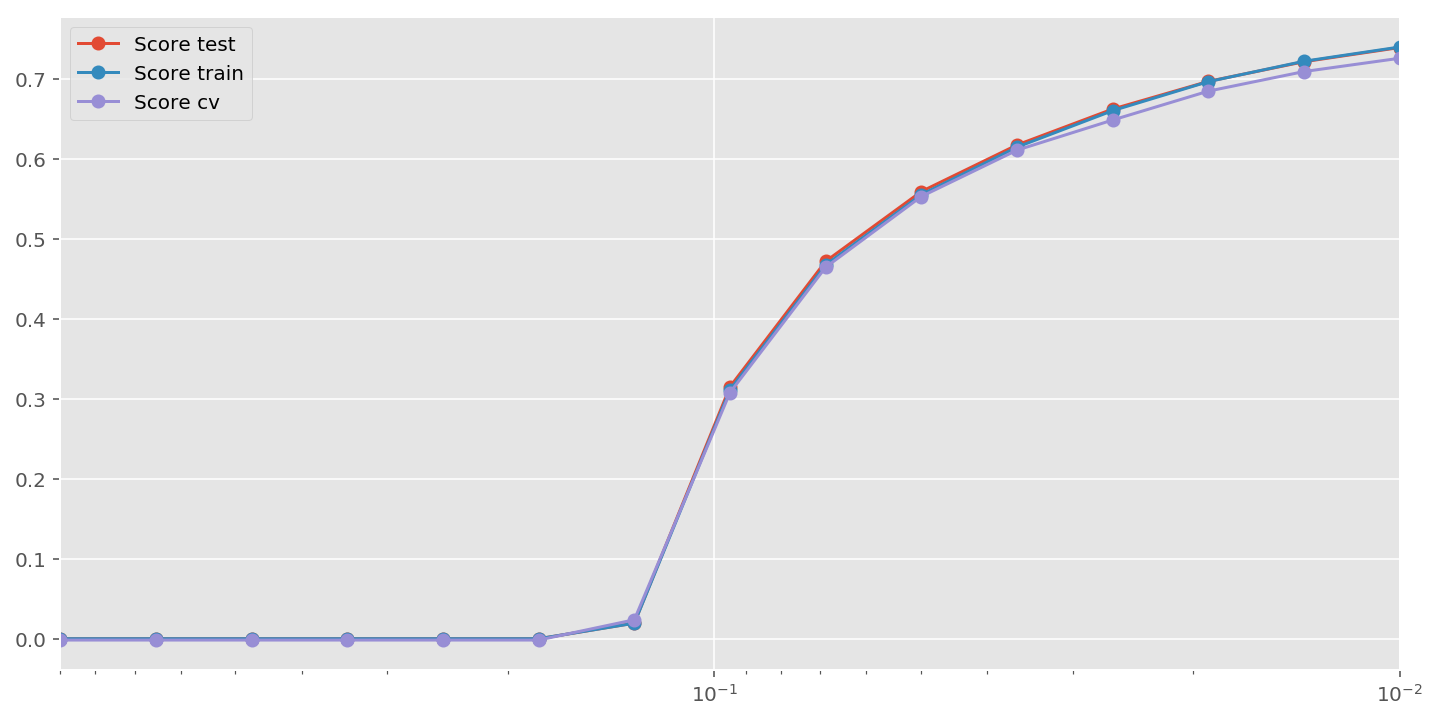

In [47]:
df_lasso[['Score test','Score train','Score cv']].plot(marker='o').semilogx()

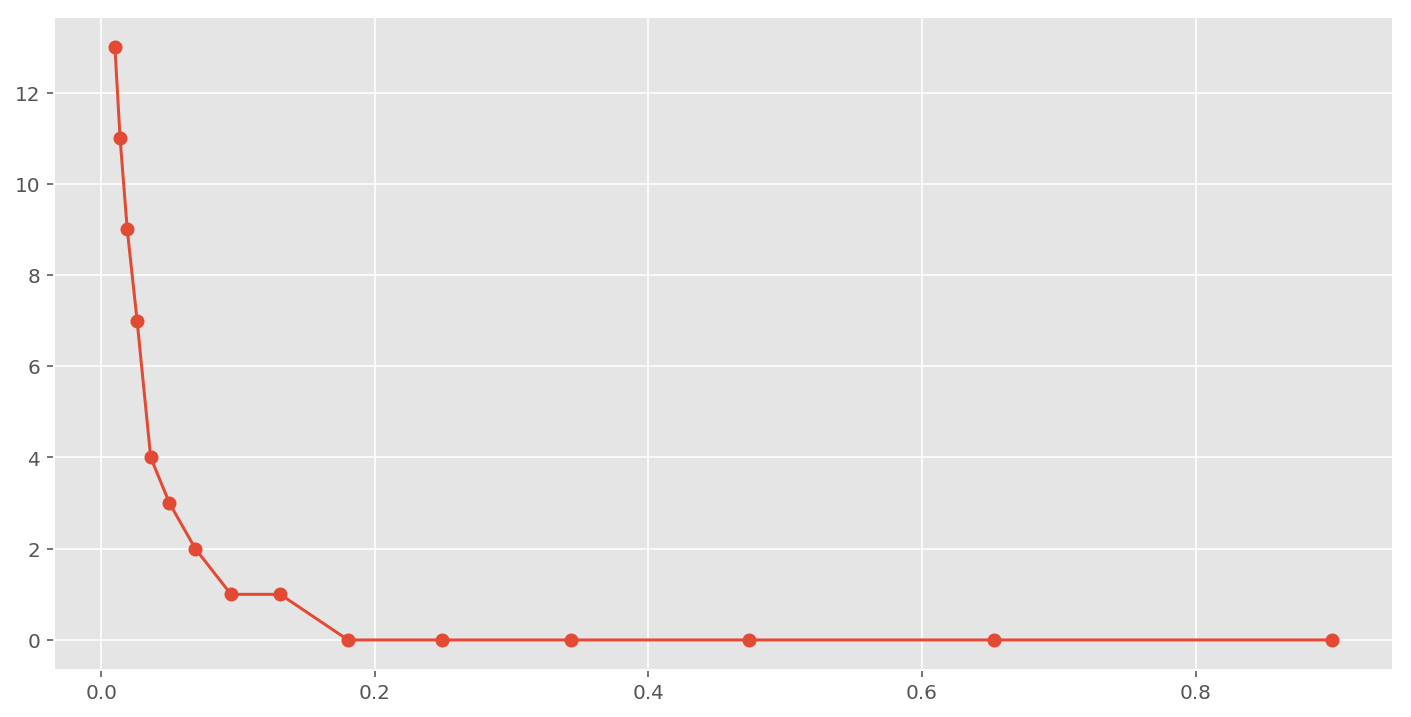

In [11]:
plt.plot(df_lasso[['N param']],marker='o')

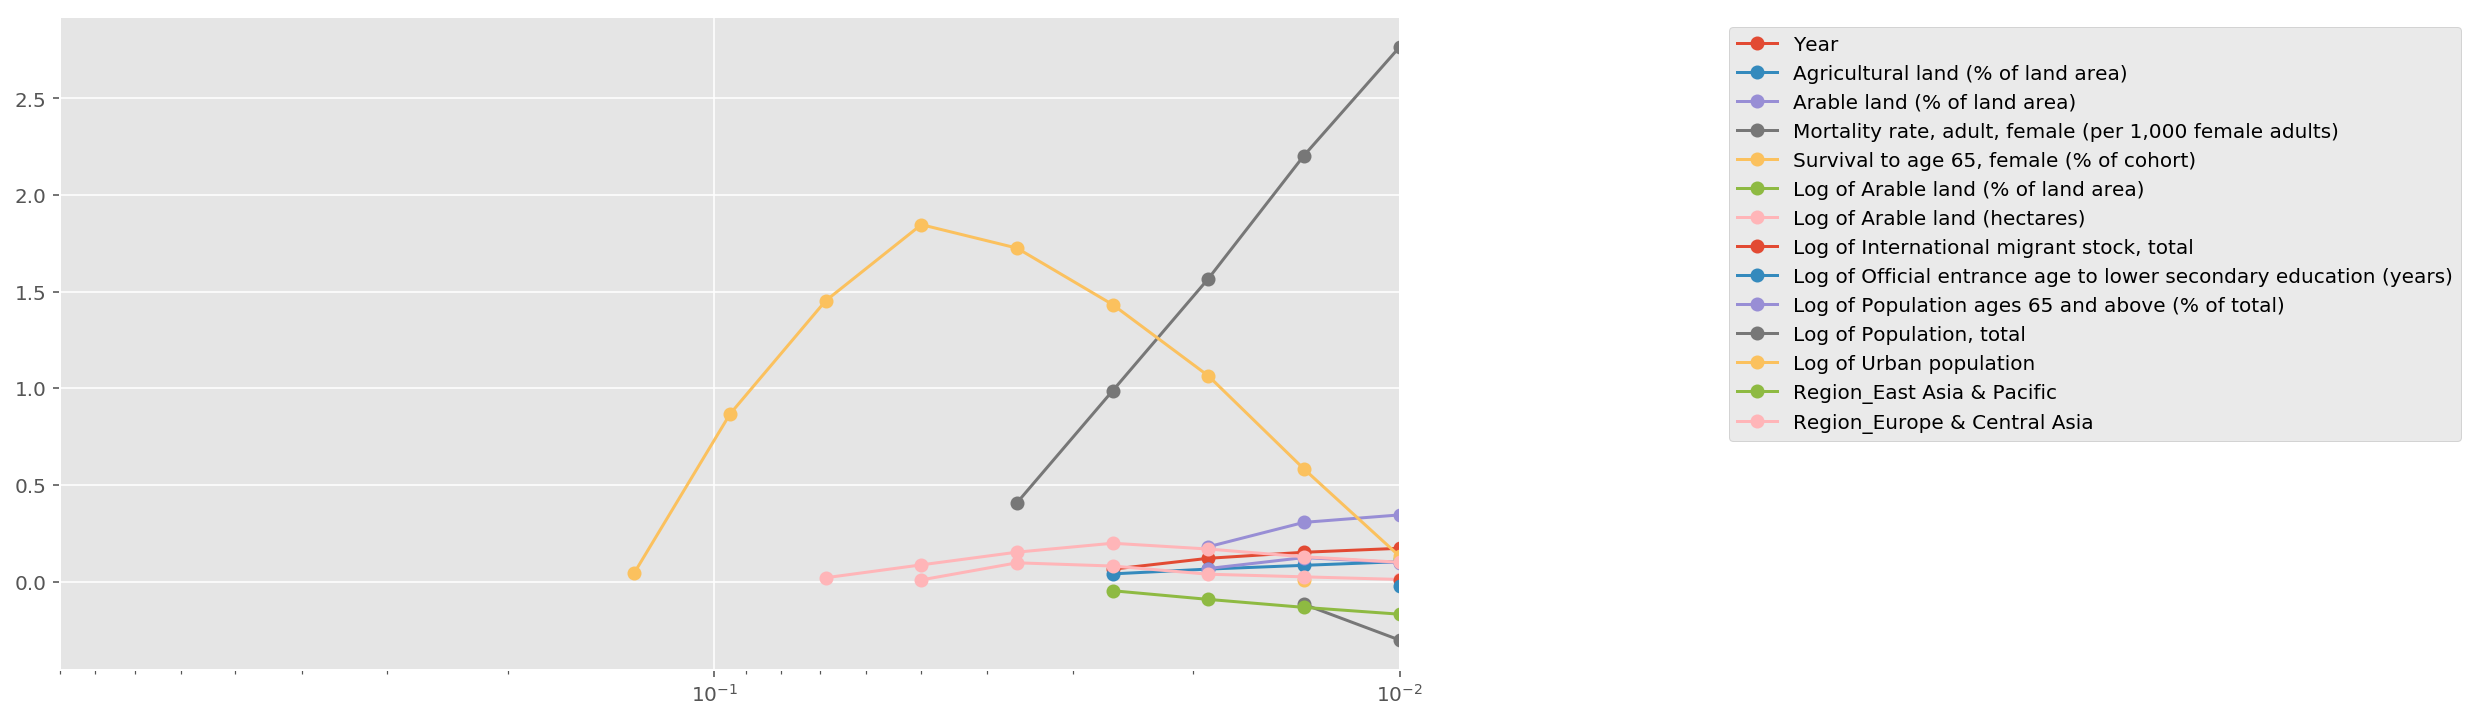

In [12]:
df_lasso_par.plot(marker='o').semilogx()
plt.legend(loc=1,ncol=1, bbox_to_anchor=(1.8, 1))

In [13]:
par_model_small = df_lasso_par.iloc[7,:].dropna()
#par_model_large = df_lasso_par.iloc[10,:].dropna()

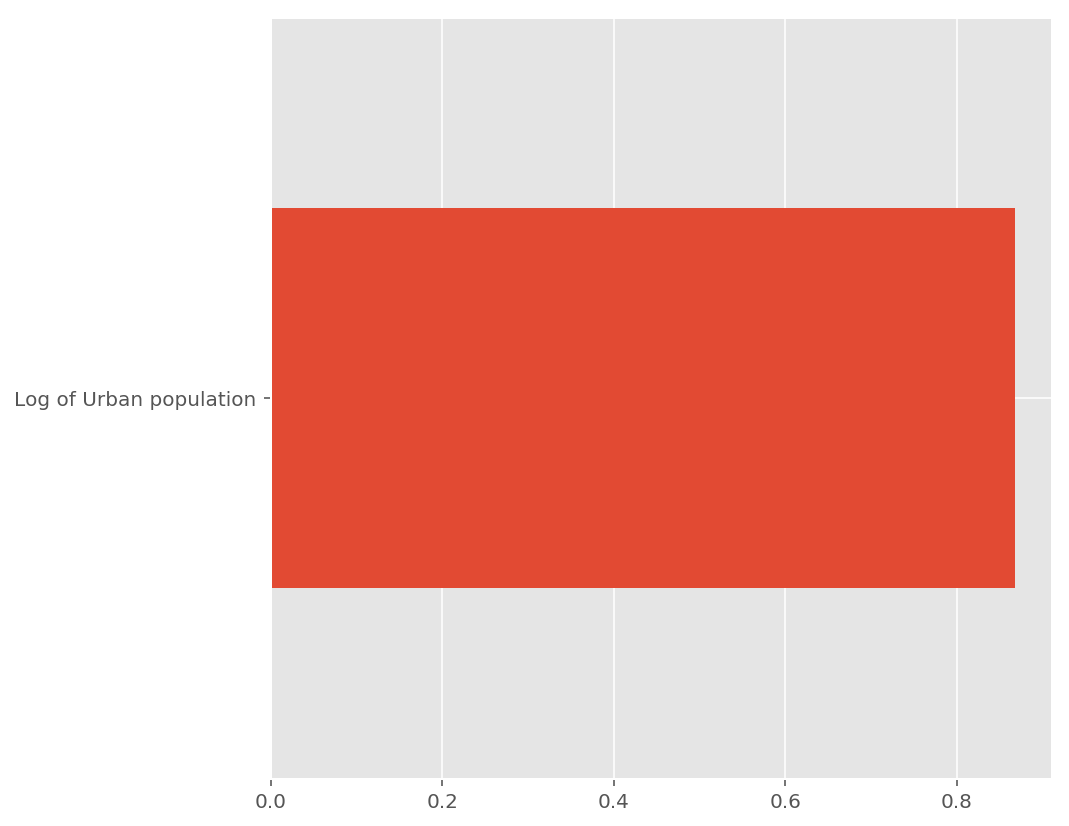

In [14]:
par_model_small.plot(kind='barh',figsize=(7,7))

In [15]:
data_model = data_tot[['Log of Emigration, total',*par_model_small.index]]

In [16]:
data_model.corr()['Log of Emigration, % pop'].drop('Log of Emigration, % pop').plot(kind='barh',figsize=(7,7))

KeyError: 'Log of Emigration, % pop'

In [ ]:
short_name_ind = []
for i in range(len(data_model.columns)): short_name_ind.append(data_model.columns[i][0:19]) 
data_model.columns = short_name_ind

In [ ]:
sns.scatterplot(y='Log of Emigration, total',x='Population growth (annual %)',data=data_tot,hue='Region')

In [ ]:
df_lasso_par['Log of GDP per capita (constant 2005 US$)']

In [ ]:
best_alpha = 0.1
best_model_lasso = LassoCV(best_alpha,max_iter=100000000,cv = 5).fit(X_train_scaled,y_train)
best_score_train = best_model_lasso.score(X_train_scaled,y_train)
best_score_test = model_lasso.score(X_test_scaled,y_test)


### Model shape

In [ ]:
print ('Log of Total Emigration = ')
print(10**model_lasso.intercept_)

for par, coeff in lasso_coeff.iteritems():
    print ('* ')
    if par[0:3]=='Log':
        print (str(par[7:]) +' ^ ' + str(coeff))
    else:
        print('exp ( '+par+' * '+str(coeff)+')')


--- 
[How to interpret parameters:]

In [ ]:
par_lasso = model_lasso.get_params()
# plt.bar(range(len(model_lasso.alphas_)),height=model_lasso.alphas_)
par_lasso

In [ ]:
plt.figure(figsize=(10,8))
sns.lmplot(data=data_corrected,x='Log of Trade (% of GDP)',y='Log of Emigration, total', hue='Log of Year')
plt.legend(['1960','1970','1980','1990','2000'])
#plt.xlim([1,3.5])
#plt.ylim([-1,2])

##### Model score

In [ ]:
model_lasso.score(X,y)